### Intro to Simulation-Based Inference, previously named as Approximate Bayes Computation  (ABC) or Likelihood Free Inference (LFI). 
#### Traditionally, in the Bayes scheme you can get the posterior given the likelihood $p(x| \theta )$ and prior $p (\theta)$ distributions: 
$$
p (\theta | x) = \frac{ p(x | \theta) p(\theta) }{ p (x)},
$$
#### where the "evidence" is calculated by 
$$
p(x) = \int_{\theta}  p (x | \theta) p (\theta) d \theta.
$$

#### Traditionally, to get the posterior we use: MCMC, Nested Sampling, Hamiltonian Monte Carlo, etc. Furthermore, the SBI approach is different, motived by: 
* What if you don't even access to the likelihood? It isn't possible express $p(x | \theta)$ analytically. But you have a stochastic process that generates the data given a parameter, so you can only sample from it. 

Note: A stochastic process is a collection of random variables, that describes the evolution of a system of random viables over time. 


$$
\theta \rightarrow Simulator \rightarrow x
$$

Now the task becomes to find the posterior distribution of the parameters given our empirical "observed data".
* We can create unlimited $x_sim$ but we want find the parameters that mostly fit the observational data. 

## Rejection Appriximate Bayes Computation
### Resources: 
* Approximate Bayesian Computation: https://bayesiancomputationbook.com/markdown/chp_08.html 
* Overview of Approximate Bayesian Computation (Slides) by Chad M. Schafer: https://indico.cern.ch/event/937896/attachments/2074639/3483509/ABClectureSchaferHandout.pdf

#### This is one of the first algorithm for the intractable likelihood problem, i.e. we don't know $p(x | \theta)$, but how we can still get a sample of the posterior $p(\theta | x)$? 

#### ABC rejection algorithm (from: https://www.researchgate.net/publication/45880117_Tutorial_on_ABC_rejection_and_ABC_SMC_for_parameter_estimation_and_model_selection )
1. Define a prior distribution $P(\theta)$ and we would like to approximate the posterior distribution  $P(\theta | D_0)$ ($D_0$ is the experimental data). First, sample a parameter 
$\theta *$ from the prior distribution, this sampled parameter is called *a particle*.
2. From a simulate data set $D*$ according to some simulation framework $f(D|\theta*)$, we compare the simulated data ser $D*$ to the experimental data $D_0$ using a distance function $d$ and a tolerance $\epsilon$, we can use these for define a condition, we accept $\theta* $ if 
$$
d(D_0,D*) \leq \epsilon. 
$$
3. We accept $\theta*$ due $D*$ and $D_0$ are sufficiently close. 
4. We repeat the whole procesdure until $N$ particles have been accepted. They represent a sample from $(P  (\theta | d(D_0, D*)) \leq \epsilon )$, which approximates the posterior distribution. 

#### However, during the process many particles were rejected in the procedure, for which we have spent a lot of computational effort for simulation. ABC rejection is therefore computationally inefficient.

#### Note: If we simulate a deterministic dynamical model, we add some noise at the time points of interest. If we simulate a stochastic dynamical model, we do not add any additional noise to the trajectories.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
import pandas as pd

In [26]:
# Estimating the mean of a normal distribution with known variancerando
# random seen 
np.random.seed(42)
# this is the true mean value 
mean_tru = 2.5

# This is the "true data"

data_obs = np.random.normal(mean_tru,1.0,100)


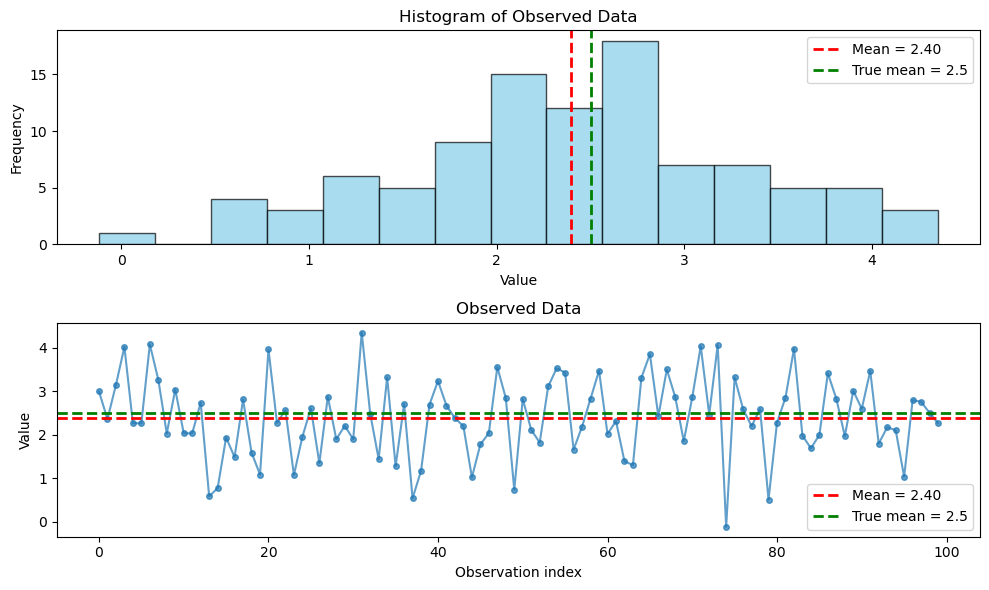


Additional statistics:
Observed data minimum: -0.120
Observed data maximum: 4.352
Observed data median: 2.373


In [27]:
plt.figure(figsize=(10, 6))

# Histogram of the observed data
plt.subplot(2, 1, 1)
plt.hist(data_obs, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(data_obs), color='red', linestyle='--', linewidth=2, label=f'Mean = {np.mean(data_obs):.2f}')
plt.axvline(mean_tru, color='green', linestyle='--', linewidth=2, label=f'True mean = {mean_tru}')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Observed Data')
plt.legend()

# Time series of the observed data
plt.subplot(2, 1, 2)
plt.plot(data_obs, 'o-', alpha=0.7, markersize=4)
plt.axhline(np.mean(data_obs), color='red', linestyle='--', linewidth=2, label=f'Mean = {np.mean(data_obs):.2f}')
plt.axhline(mean_tru, color='green', linestyle='--', linewidth=2, label=f'True mean = {mean_tru}')
plt.xlabel('Observation index')
plt.ylabel('Value')
plt.title('Observed Data')
plt.legend()

plt.tight_layout()
plt.show()

# Print some additional statistics
print(f"\nAdditional statistics:")
print(f"Observed data minimum: {np.min(data_obs):.3f}")
print(f"Observed data maximum: {np.max(data_obs):.3f}")
print(f"Observed data median: {np.median(data_obs):.3f}")

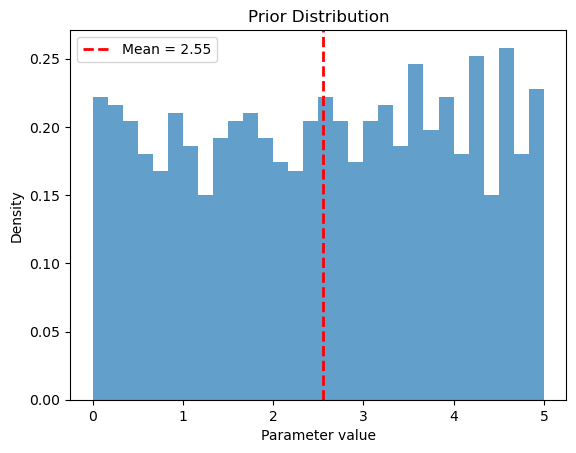

In [44]:
# The next step is define a prior distribution 
def prior():
    # uniform distribution from 0 to 5 
    return uniform.rvs(loc=0,scale=5)


prior_samples = [prior() for _ in range(1000)]
plt.hist(prior_samples, bins=30, density=True, alpha=0.7)
plt.axvline(np.mean(prior_samples), color='red', linestyle='--', linewidth=2, label=f'Mean = {np.mean(prior_samples):.2f}')
plt.xlabel('Parameter value')
plt.ylabel('Density')
plt.title('Prior Distribution')
plt.legend()
plt.show()


(array([0.05989005, 0.17967014, 0.        , 0.        , 0.35934028,
        0.11978009, 0.29945023, 0.41923032, 0.29945023, 0.23956018,
        0.41923032, 0.41923032, 0.53901041, 0.47912037, 0.29945023,
        0.41923032, 0.17967014, 0.23956018, 0.23956018, 0.23956018,
        0.05989005, 0.05989005, 0.11978009, 0.11978009, 0.        ,
        0.11978009, 0.        , 0.        , 0.        , 0.05989005]),
 array([-0.51198137, -0.34500871, -0.17803606, -0.0110634 ,  0.15590926,
         0.32288191,  0.48985457,  0.65682722,  0.82379988,  0.99077253,
         1.15774519,  1.32471784,  1.4916905 ,  1.65866315,  1.82563581,
         1.99260846,  2.15958112,  2.32655377,  2.49352643,  2.66049908,
         2.82747174,  2.99444439,  3.16141705,  3.3283897 ,  3.49536236,
         3.66233502,  3.82930767,  3.99628033,  4.16325298,  4.33022564,
         4.49719829]),
 <BarContainer object of 30 artists>)

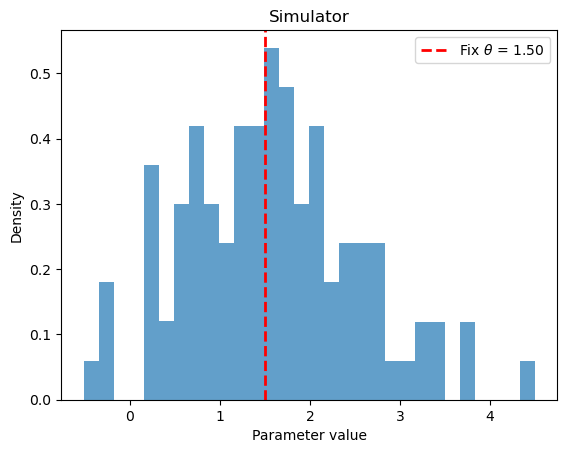

In [54]:
# step 3: Now we need define a simulatior, from a parameter theta 

def simulator(theta):
    return np.random.normal(theta,1,100)

# keep in main that this parameter represent the mean of the distribution 
fix_theta = 1.5
test_simulator1 = simulator(fix_theta)
plt.axvline(1.5, color='red', linestyle='--', linewidth=2, label=f'Fix $\\theta$ = {fix_theta:.2f}')
plt.legend()
plt.ylabel("Density")
plt.xlabel("Parameter value")
plt.title("Simulator")
plt.hist(test_simulator1, bins=30, density=True, alpha=0.7)


In [56]:
# step 4: We need to choose a rule of "closeness" of our simulations with the true observations.
# we use the simplest rule of distance for this 
def distance(observed, simulated):
    return abs(np.mean(observed) - np.mean(simulated))

# Test the distance function
test_distance = distance(data_obs,test_simulator1)
print(f"Distance between observed and simulated data: {test_distance:.3f}")


Distance between observed and simulated data: 0.824


In [57]:
# step 5: implement the ABC rejection algorith with the observational data, the prior distribution and 
# the simulator. 
def abc_rejection(prior, simulator, distance, observed_data, epsilon, n_accepted):
    """
    epsilon: tolerance threshold for accepting parameters
    n_accepted: number of particles to accept
    
    Returns:
    accepted_particles: list of accepted parameter values
    total_simulations: total number of simulations performed
    """
    
    # Initialize an empty list to store accepted particles
    accepted_particles = []
    total_simulations = 0
    
    print(f"Starting ABC rejection. Need to accept {n_accepted} particles.")
    
    while len(accepted_particles) < n_accepted:
        # Step 1: Sample a parameter from the prior distribution (a particle)
        theta_star = prior()
        
        # Step 2: Simulate data using the sampled parameter
        simulated_data = simulator(theta_star)
        
        # Count the total number of simulations
        total_simulations += 1
        
        # Step 3: Calculate distance between simulated and observed data
        d = distance(observed_data, simulated_data)
        
        # Step 4: Accept the particle if distance is within tolerance
        if d <= epsilon:
            accepted_particles.append(theta_star)
            
            # Print progress every 10 accepted particles
            if len(accepted_particles) % 10 == 0:
                print(f"Accepted {len(accepted_particles)} particles. "
                      f"Acceptance rate: {len(accepted_particles)/total_simulations:.4f}")
    
    # Return the accepted particles
    print(f"Completed! Total simulations: {total_simulations}. "
          f"Final acceptance rate: {len(accepted_particles)/total_simulations:.4f}")
    
    return np.array(accepted_particles), total_simulations

In [63]:
# step 6: Run the rejection ABC algorithm 
epsilon = 0.0002

# Number of particles to accept
n_accepted = 100

# Run the ABC rejection algorithm
accepted_particles, total_simulations = abc_rejection(
    prior, simulator, distance, data_obs, epsilon, n_accepted
)

Starting ABC rejection. Need to accept 100 particles.
Accepted 10 particles. Acceptance rate: 0.0001
Accepted 20 particles. Acceptance rate: 0.0001
Accepted 30 particles. Acceptance rate: 0.0001
Accepted 40 particles. Acceptance rate: 0.0001
Accepted 50 particles. Acceptance rate: 0.0001
Accepted 60 particles. Acceptance rate: 0.0001
Accepted 70 particles. Acceptance rate: 0.0001
Accepted 80 particles. Acceptance rate: 0.0001
Accepted 90 particles. Acceptance rate: 0.0001
Accepted 100 particles. Acceptance rate: 0.0001
Completed! Total simulations: 1132410. Final acceptance rate: 0.0001



Algorithm efficiency: 0.0001 (0.01% of simulations were accepted)


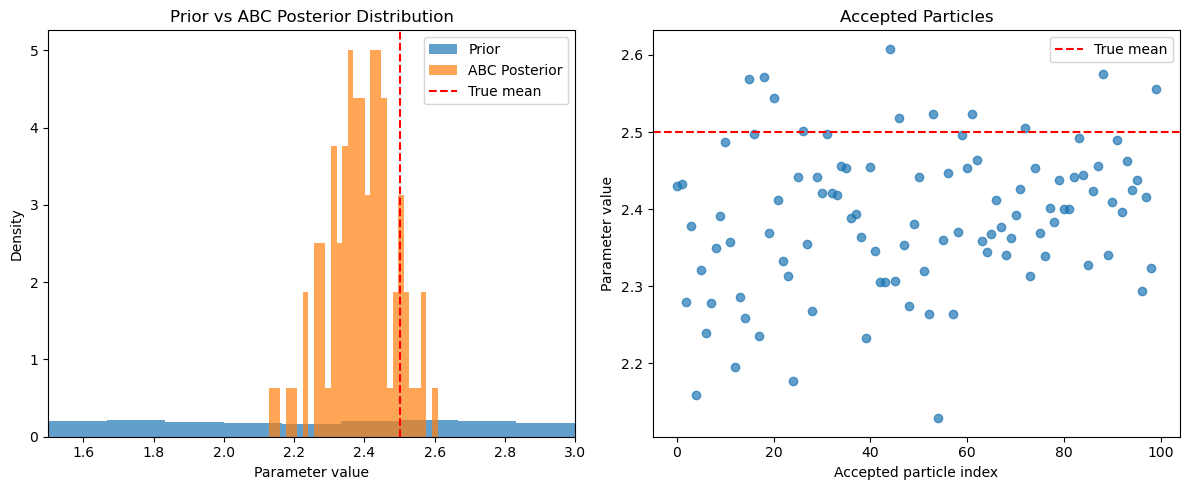


Summary statistics:
True parameter value: 2.500
Mean of accepted particles: 2.389
Standard deviation of accepted particles: 0.094
95% credible interval: [2.186, 2.570]


In [65]:
# Calculate efficiency
efficiency = n_accepted / total_simulations
print(f"\nAlgorithm efficiency: {efficiency:.4f} "
      f"({efficiency*100:.2f}% of simulations were accepted)")

# Plot results
plt.figure(figsize=(12, 5))

# Plot 1: Prior vs posterior distribution
plt.subplot(1, 2, 1)
plt.hist(prior_samples, bins=30, density=True, alpha=0.7, label='Prior')
plt.hist(accepted_particles, bins=30, density=True, alpha=0.7, label='ABC Posterior')
plt.axvline(mean_tru, color='red', linestyle='--', label='True mean')
plt.xlabel('Parameter value')
plt.ylabel('Density')
plt.title('Prior vs ABC Posterior Distribution')
plt.xlim(1.5,3.0)
plt.legend()

# Plot 2: Accepted particles with distance information
plt.subplot(1, 2, 2)
plt.scatter(range(len(accepted_particles)), accepted_particles, alpha=0.7)
plt.axhline(mean_tru, color='red', linestyle='--', label='True mean')
plt.xlabel('Accepted particle index')
plt.ylabel('Parameter value')
plt.title('Accepted Particles')
plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary statistics:")
print(f"True parameter value: {mean_tru:.3f}")
print(f"Mean of accepted particles: {np.mean(accepted_particles):.3f}")
print(f"Standard deviation of accepted particles: {np.std(accepted_particles):.3f}")
print(f"95% credible interval: [{np.percentile(accepted_particles, 2.5):.3f}, "
      f"{np.percentile(accepted_particles, 97.5):.3f}]")